### Notebook Overview

Original Data Source (Kaggle) - https://www.kaggle.com/datasets/thedevastator/predicting-credit-card-customer-attrition-with-m
Synthetic Data Generation Source (Mostly AI) - https://mostly.ai/


Data found in '/Raw Data/' directory:
- BankChurners.csv: original data pulled from kaggle as is (10,127 rows)
- BankChurners_Synthetic1.csv: synthetic data generated from BankChurners.csv using Mostly AI (10,127 rows)
- BankChurners_Synthetic2.csv: additional synthetic data generated from BankChurners.csv using Mostly AI (50,000 rows)

Notebook goals and functionality:
- read original Kaggle data and combine with synthetic data, add a 'data_version' label to differentiate original (0), first batch synthetic (1), and second batch synthetic (2) data sources for testing downstream data drift
- drop extraneous fields that will not be used for modeling
- pre-process original data for model ingestion (one-hot encoding, training/testing split)
- log a random forest model using MLflow and register the model in the model registry
- use registered model for inference on both synthetic datasets
- apply statistical methods to detect data drift

In [179]:
# Uncomment the below line and execute prior to running any remaining cells in the notebook to set up the MLFlowUI, 
# the link below can be used to access the UI in your browser after you stop this cell's execution

# ! mlflow ui

Access MLFlow Server Locally: http://localhost:5000/

In [301]:
# import nececssary libraries
from sklearn.model_selection import train_test_split
import pandas as pd
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, accuracy_score
from mlflow.models.signature import infer_signature
from mlflow.tracking.client import MlflowClient
import mlflow.pyfunc
import matplotlib.pyplot as plt
import numpy as np
import uuid
import time
import seaborn as sns
from scipy import stats

### Data Ingestion and ML Pre-processing

In [181]:
raw_data_dir = './Raw Data/'

# downloaded from kaggle
real_data_df = pd.read_csv(raw_data_dir + 'BankChurners.csv')
synthetic_data_df1 = pd.read_csv(raw_data_dir + 'BankChurners_Synthetic1.csv')
synthetic_data_df2 = pd.read_csv(raw_data_dir + 'BankChurners_Synthetic2.csv')

In [182]:
# add a 'data_version' label for each dataset and drop unnecessary columns
real_data_df.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)
real_data_df['data_label'] = 0

synthetic_data_df1.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)
synthetic_data_df1['data_label'] = 1

synthetic_data_df2.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)
synthetic_data_df2['data_label'] = 2

In [183]:
# concatenate all datasets
combined_df = pd.concat([real_data_df, synthetic_data_df1, synthetic_data_df2])

In [184]:
synthetic_data_df2.columns

Index(['Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
       'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category',
       'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'data_label'],
      dtype='object')

In [185]:
modeling_df = combined_df.copy()

# turn categorical label to boolean prior to model training
modeling_df['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0}, inplace=True)

# reformat categorical values so that one-hot enconding results in usable column names
modeling_df['Income_Category'].replace({'Less than $40K': 'under_40', 
                                        '$40K - $60K': '40_to_60', 
                                        '$80K - $120K': '80_to_120',
                                        '$60K - $80K': '60_to_80',
                                        '$120K +': 'over_120'}, inplace=True)

# one-hot encode categorical features
cat_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

print(f'Before Column Count: {modeling_df.shape[1]}')
for col in cat_cols:
    dummies = pd.get_dummies(modeling_df[col], prefix=col)
    modeling_df = pd.concat([modeling_df, dummies], axis='columns')
    modeling_df.drop([col], axis='columns', inplace=True)
print(f'After Column Count: {modeling_df.shape[1]}')

Before Column Count: 21
After Column Count: 39


In [186]:
# create testing/training split for the original kaggle data
raw_modeling_df = modeling_df[modeling_df['data_label'] == 0]
raw_modeling_df.drop('data_label', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(raw_modeling_df.drop('Attrition_Flag', axis=1), raw_modeling_df['Attrition_Flag'], random_state=42, test_size=.3)

C:\Users\Alex\AppData\Local\Temp\ipykernel_456\2101816980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_modeling_df.drop('data_label', axis=1, inplace=True)


### Model Training and Scoring

In [219]:
# define model training and logging function
def train_and_log_model(X_test, X_train, y_test, y_train, run_name):
    '''
    A function to train a random forest model and log the associated metrics, parameters, feature importance, and figures.
    Accepts testing and training pandas dataframes for both features and labels as well as a run name, which is made unique
    in the case that the function is run multiple times. The function returns the associated model uri for the logged model 
    for further model registration and management.
    '''
    
    # generate and append uuid for unique run name
    unique_run_name = run_name + '_' + str(uuid.uuid4())[:6]
    with mlflow.start_run(run_name=unique_run_name) as run:
        signature = infer_signature(X_test, pd.DataFrame(y_test))

        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train.values.ravel())
        predictions = rf.predict(X_test)

        f1 = f1_score(predictions, y_test)
        roc_auc = roc_auc_score(predictions, y_test)
        balanced_accuracy = balanced_accuracy_score(predictions, y_test)
        accuracy = accuracy_score(predictions, y_test)


        # log model w/signature and input example
        mlflow.sklearn.log_model(rf, 'rf_model', signature=signature, input_example=X_train[:3])

        # log metrics
        mlflow.log_metric('f1', f1)
        mlflow.log_metric('roc_auc', roc_auc)
        mlflow.log_metric('balanced_accuracy', balanced_accuracy)
        mlflow.log_metric('accuracy', accuracy)

        # log parameters
        mlflow.log_params(rf.get_params())

        # get and log feature importance
        # create and log csv 
        importances = pd.DataFrame(list(zip(X_train.columns, rf.feature_importances_)), columns = ['column', 'mde']).sort_values('mde', ascending=False)
        importances_series = pd.Series(rf.feature_importances_, index=X_train.columns)
        artifact_path = './'
        importance_path = artifact_path + 'importance.csv'

        importance_df = importances.to_csv(importance_path)
        mlflow.log_artifact(importance_path, "importance.csv")

        # create and log feature importance plot
        fig, ax = plt.subplots()
        importances_series.plot.bar(ax=ax)
        plt.title('Feature Importance')
        mlflow.log_figure(fig, "feature_importance.png")

        # create and log ROC AUC plot
        # predict probabilities
        rf_probs = rf.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        rf_probs = rf_probs[:, 1]
        # get scoring values for plotting
        fpr, tpr, _ = roc_curve(y_test, rf_probs)
        fig, ax = plt.subplots()
        plt.plot(fpr, tpr, label='random forest roc curve')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        mlflow.log_figure(fig, "roc_plot.png")

        print(f'Experiment ID: {run.info.experiment_id}')
        print(f'Run ID: {run.info.run_id}')
        
        return run.info.experiment_id, f'runs:/{run.info.run_id}/rf_model', unique_run_name

C:\Users\Alex\anaconda3\lib\site-packages\mlflow\models\signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
C:\Users\Alex\anaconda3\lib\site-packages\mlflow\models\signature.py:138: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data conta

Experiment ID: 0
Run ID: 5db7c220223543d08b54a76ac0ea0475


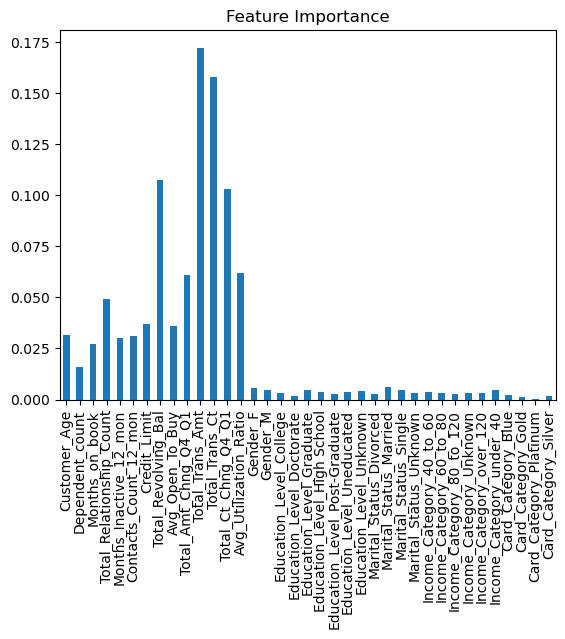

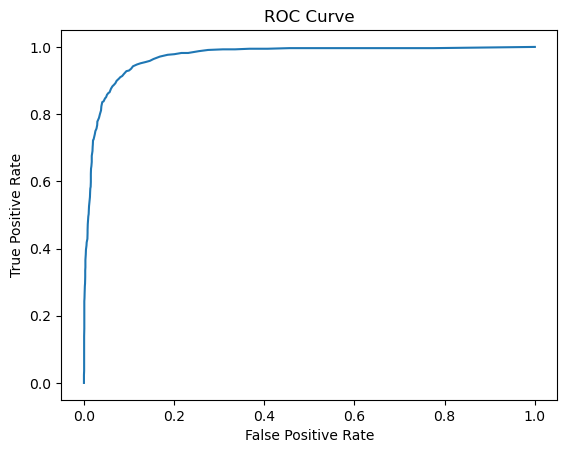

In [220]:
experiment_id, model_uri, last_run_name = train_and_log_model(X_test, X_train, y_test, y_train, 'rf_model')

In [246]:
# pulls metrics from run and send to df for plotting
# specify query to filter to the last run, based on the unique run name created
query = f"tags.`mlflow.runName` = '{last_run_name}'"
runs = client.search_runs(experiment_id, filter_string = query)[0]

metrics_dict = runs.data.metrics
metrics_dict['data_label'] = 0
metrics_df = pd.DataFrame([metrics_dict])

In [221]:
# register model so it can easily be used for inference with synthetic data
original_model_name = 'rf_model_original'
model_details = mlflow.register_model(model_uri=model_uri, name=original_model_name)

# use MlFlow Client to add a description to the model
client = MlflowClient()
client.update_registered_model(name=model_details.name, description="Random forest model trained on all original, non-synthetic data from the source.")

# load registered model based on the latest version - wait 20 seconds for the above commands to finish running
time.sleep(20)
model_versions = client.search_model_versions(f'name="{original_model_name}"')
latest_model_version = model_versions[0].version
print(f'Latest Model Version: {latest_model_version}')

model_version_uri = f'models:/{original_model_name}/{latest_model_version}'
loaded_original_model = mlflow.pyfunc.load_model(model_version_uri)

Registered model 'rf_model_original' already exists. Creating a new version of this model...
2023/06/29 12:01:18 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: rf_model_original, version 5
Created version '5' of model 'rf_model_original'.
2023/06/29 12:01:38 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Latest Model Version: 5


### Inference on Synthetic Data

In [247]:
# create a function for inference and scoring using a registered model
def batch_inference_and_scoring(feature_df, label_df, loaded_model):
    predictions = loaded_model.predict(feature_df)
    
    # calculate scores across batch predictions and labels
    f1 = f1_score(predictions, label_df)
    roc_auc = roc_auc_score(predictions, label_df)
    balanced_accuracy = balanced_accuracy_score(predictions, label_df)
    accuracy = accuracy_score(predictions, label_df)
    
    metrics_dict = {'accuracy': accuracy, 'balanced_accuracy': balanced_accuracy, 'f1': f1, 'roc_auc': roc_auc}

    metrics_df = pd.DataFrame([metrics_dict])
    
    # returns a dataframe of metrics for the given batch
    return metrics_df

In [250]:
# filter to first batch of synthetic data
synthetic_modeling_df1 = modeling_df[modeling_df['data_label'] == 1]
synthetic_modeling_df1.drop('data_label', axis=1, inplace=True)

synthetic_batch_scoring1 = batch_inference_and_scoring(synthetic_modeling_df1.drop('Attrition_Flag', axis=1), synthetic_modeling_df1['Attrition_Flag'], loaded_original_model)
synthetic_batch_scoring1['data_label'] = 1

C:\Users\Alex\AppData\Local\Temp\ipykernel_456\4245852335.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_modeling_df1.drop('data_label', axis=1, inplace=True)


In [251]:
# filter to second batch of synthetic data
synthetic_modeling_df2 = modeling_df[modeling_df['data_label'] == 2]
synthetic_modeling_df2.drop('data_label', axis=1, inplace=True)

synthetic_batch_scoring2 = batch_inference_and_scoring(synthetic_modeling_df2.drop('Attrition_Flag', axis=1), synthetic_modeling_df2['Attrition_Flag'], loaded_original_model)
synthetic_batch_scoring2['data_label'] = 2

C:\Users\Alex\AppData\Local\Temp\ipykernel_456\3776992113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  synthetic_modeling_df2.drop('data_label', axis=1, inplace=True)


### Drift Monitoring and Detection

In [291]:
# combine dataframes for each round of batch inference (3)
combined_metrics_df = pd.concat([metrics_df, synthetic_batch_scoring1, synthetic_batch_scoring2])
combined_metrics_df = combined_metrics_df.set_index('data_label')

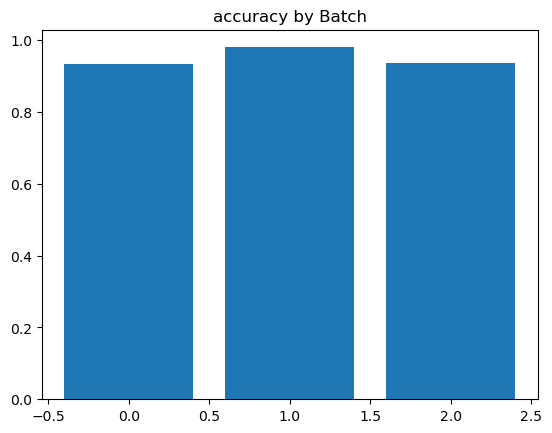

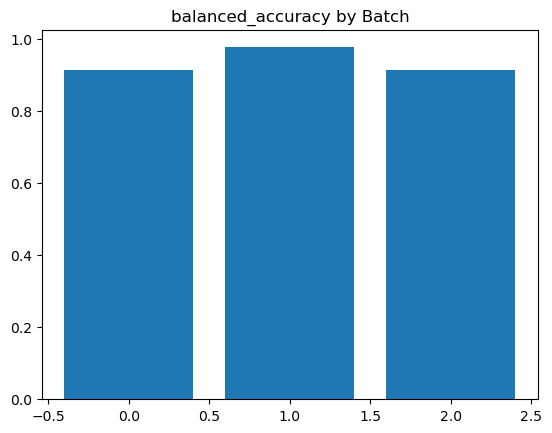

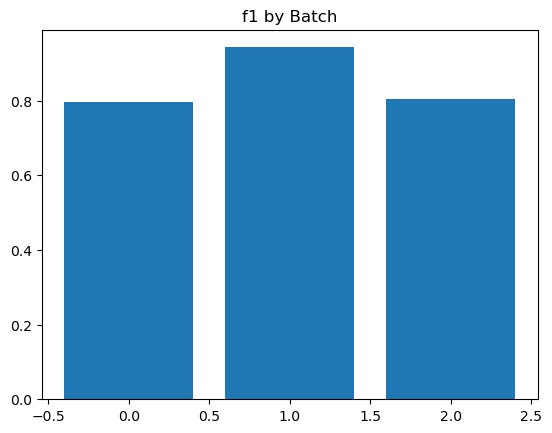

In [293]:
for col in combined_metrics_df.columns[:-1]:
    fig, ax = plt.subplots()
    plt.title(f"{col} by Batch")
    ax.bar(combined_metrics_df.index, combined_metrics_df[f'{col}'])

### Assessment of Drift (Eye Test)

Based on the batch inference and resulting metrics above, there doesn't seem to be clear signs of drift and model degradation. In fact, the model trained on the original data achieves better metrics when predicting on synthetic data. This is likely an underlying issue with overfitting from the synthetic data creation. 

Different types of drift will be forced manually to verify the tools built for monitoring are functioning correctly.

### Drift Monitoring Tools

In [312]:
# Kolmogorov-Smirnof Test
# use case: used for numeric features to test if two given samples come from the same distribution. 
# Based on a specific p-value (alpha). Not useful for larger datasets (~100K).

# raw_modeling_df
# synthetic_modeling_df1
# synthetic_modeling_df2
# Total_Trans_Amt

# plot distributions
def get_kde_plot(distribution_1, distribution_2):
    sns.kdeplot(distribution_1, fill=True, label=1)
    sns.kdeplot(distribution_2, fill=True, label=2)
    plt.legend(loc='upper right')
    plt.show()

# calculate p-value of K-S Test
def calculate_ks(distribution_1, distribution_2, alpha):
    p_value = np.round(stats.ks_2samp(distribution_1, distribution_2)[1], 3)
    has_drift = p_value < alpha

    return has_drift

No Drift Detected: Customer_Age


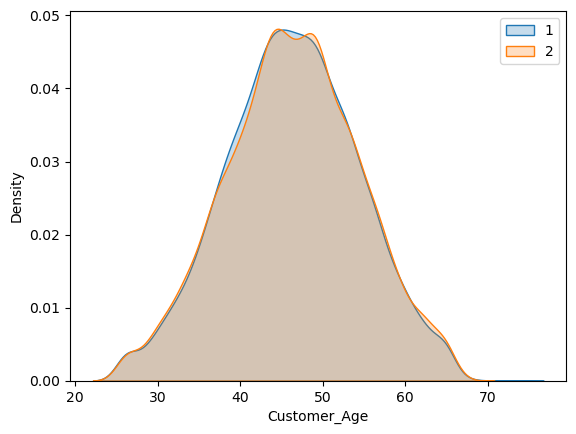

No Drift Detected: Dependent_count


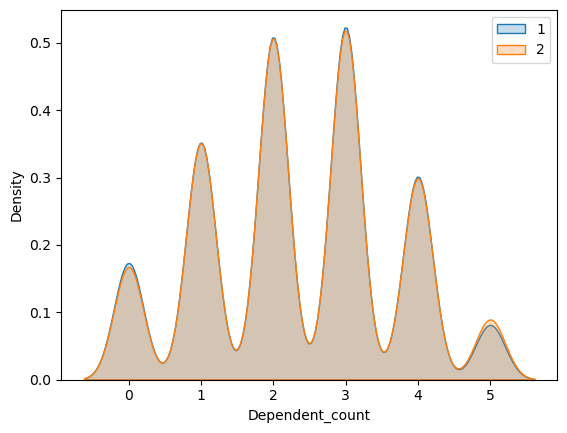

No Drift Detected: Months_on_book


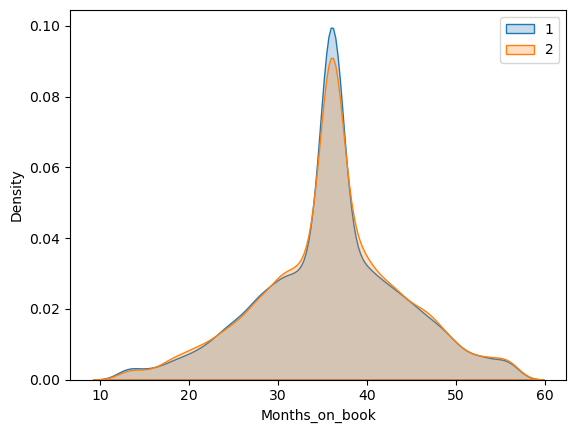

No Drift Detected: Total_Relationship_Count


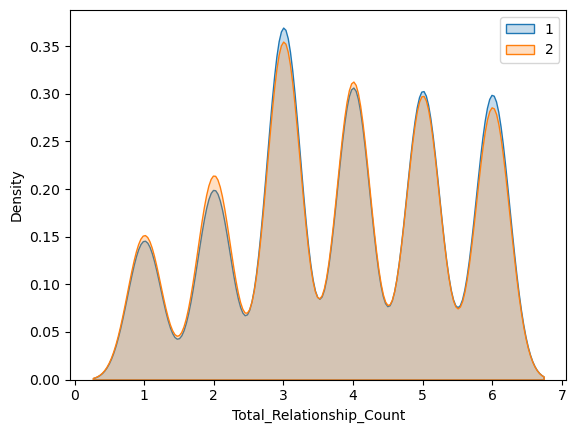

No Drift Detected: Months_Inactive_12_mon


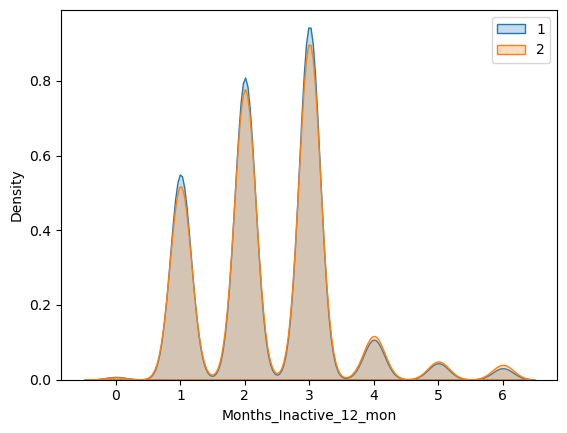

No Drift Detected: Contacts_Count_12_mon


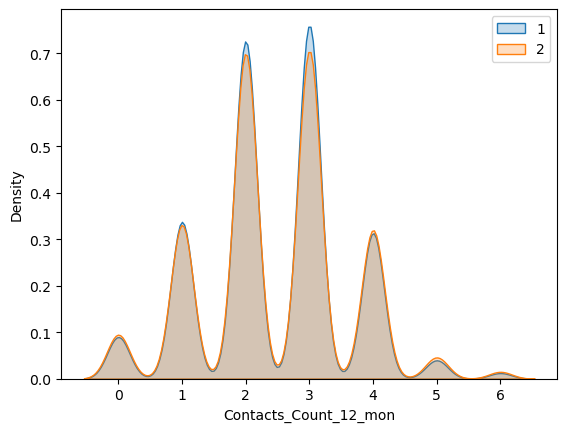

No Drift Detected: Credit_Limit


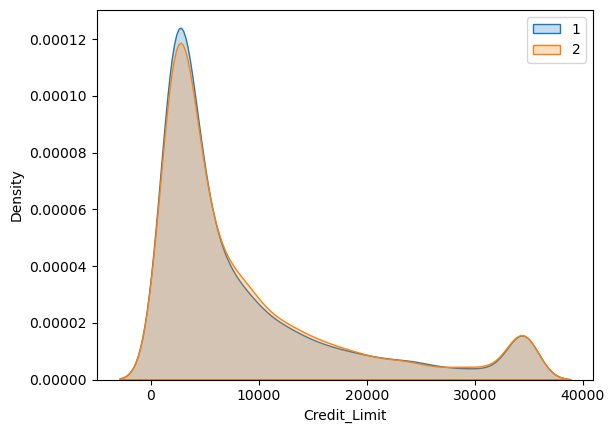

No Drift Detected: Total_Revolving_Bal


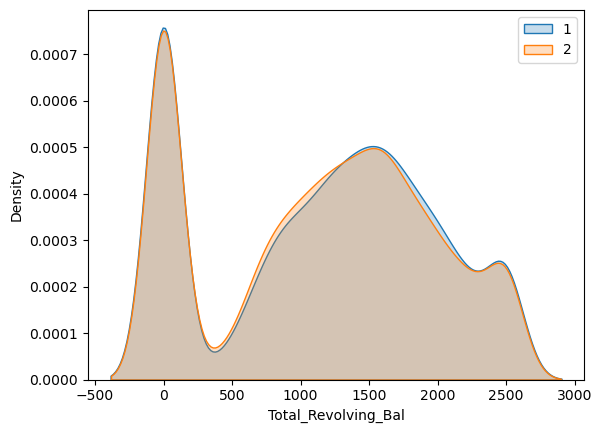

No Drift Detected: Avg_Open_To_Buy


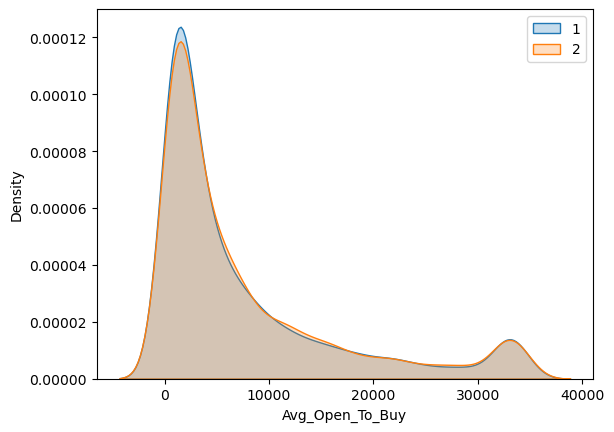

No Drift Detected: Total_Amt_Chng_Q4_Q1


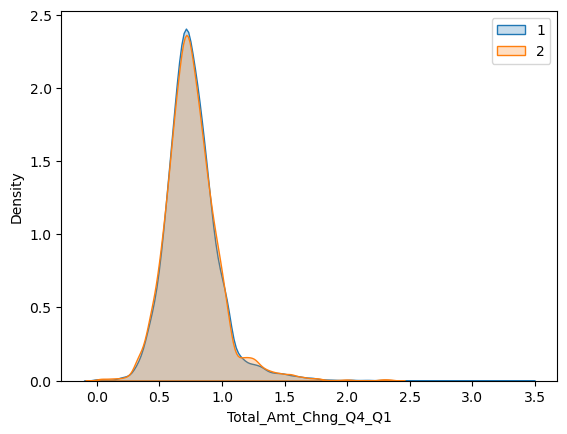

No Drift Detected: Total_Trans_Amt


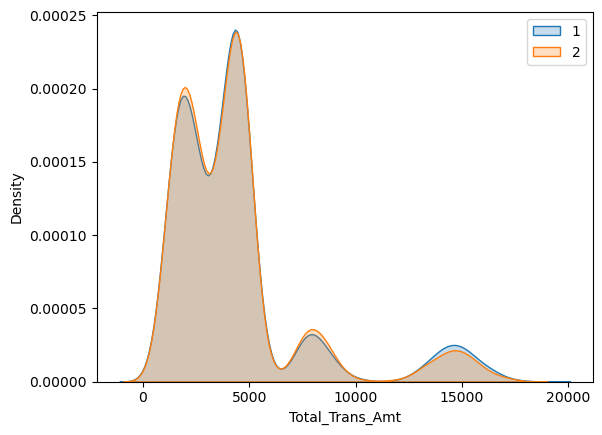

No Drift Detected: Total_Trans_Ct


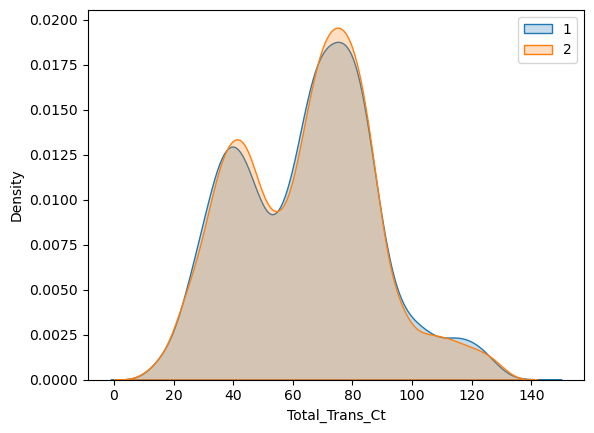

No Drift Detected: Total_Ct_Chng_Q4_Q1


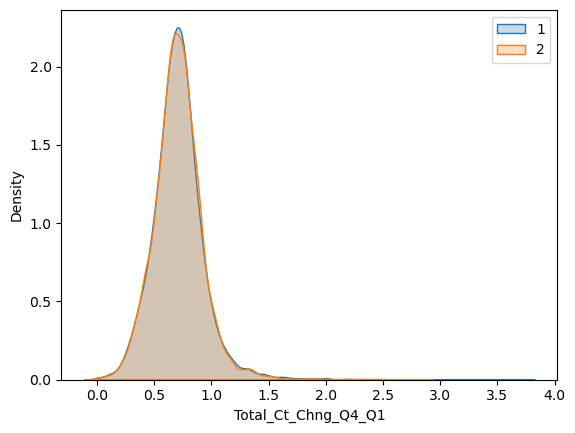

No Drift Detected: Avg_Utilization_Ratio


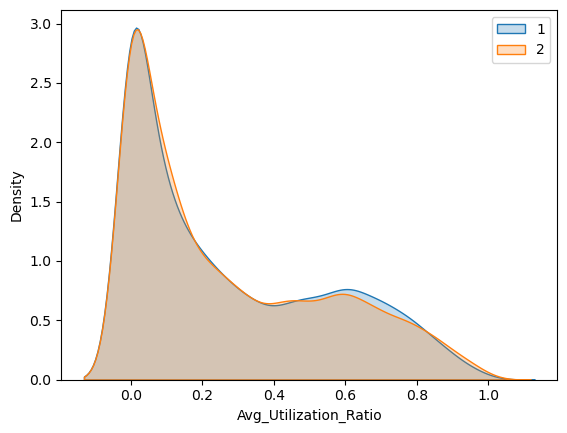

In [313]:
# calculate drift for numerical columns
num_col = ['Customer_Age', 'Dependent_count','Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
           'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 
           'Total_Trans_Amt','Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

# use bonferroni correction for alpha to reduce risk of false positive (= orginal alpha / number of tests in group)
corrected_alpha = .05 / len(num_col)

# test drift for original data and first batch of synthetic data
for col in num_col:
    distribution_1 = raw_modeling_df[col]
    distribution_2 = synthetic_modeling_df1[col]
    
    has_drift = calculate_ks(distribution_1, distribution_2, corrected_alpha)
    print(f'Drift Detected: {col}') if has_drift else print(f'No Drift Detected: {col}')
    
    get_kde_plot(distribution_1, distribution_2)

No Drift Detected: Customer_Age


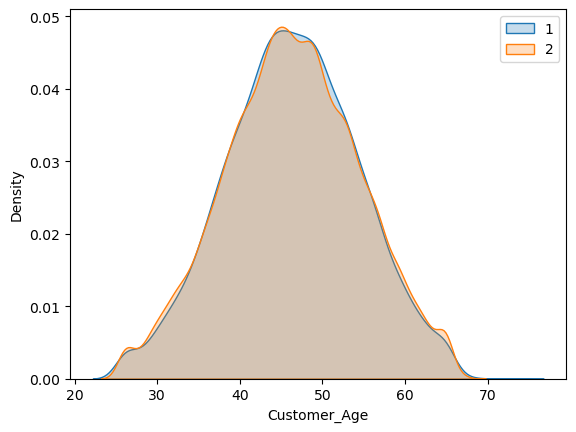

No Drift Detected: Dependent_count


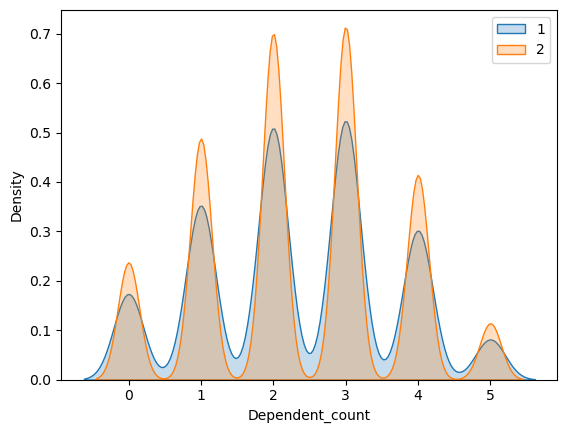

No Drift Detected: Months_on_book


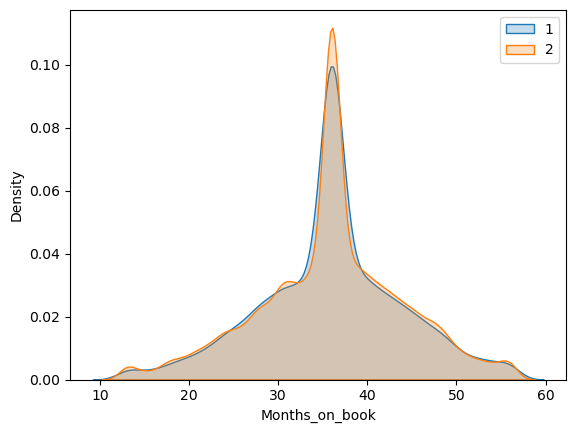

No Drift Detected: Total_Relationship_Count


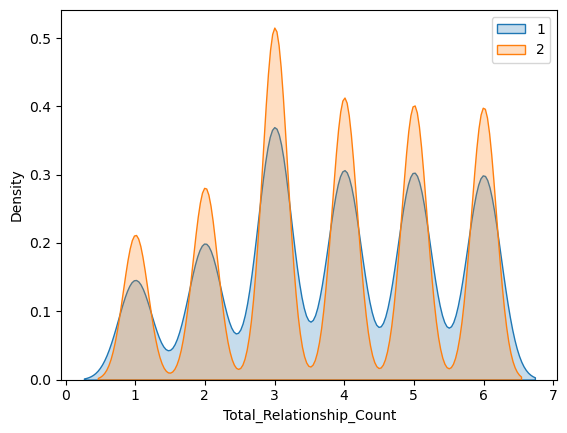

No Drift Detected: Months_Inactive_12_mon


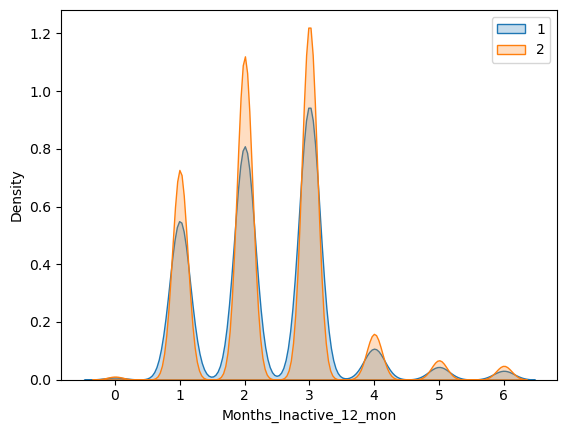

No Drift Detected: Contacts_Count_12_mon


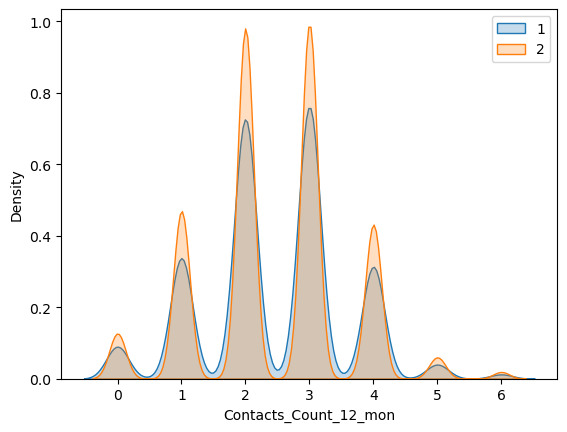

Drift Detected: Credit_Limit


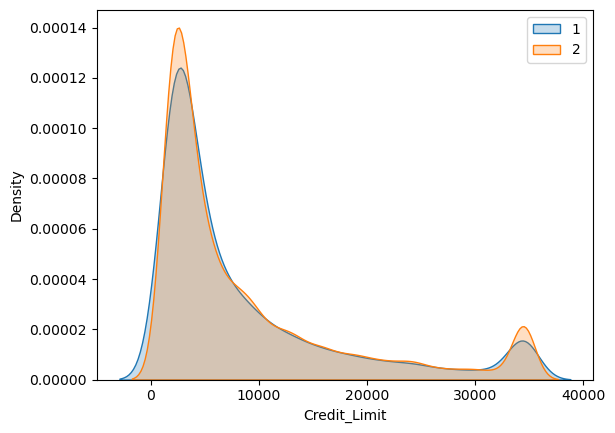

No Drift Detected: Total_Revolving_Bal


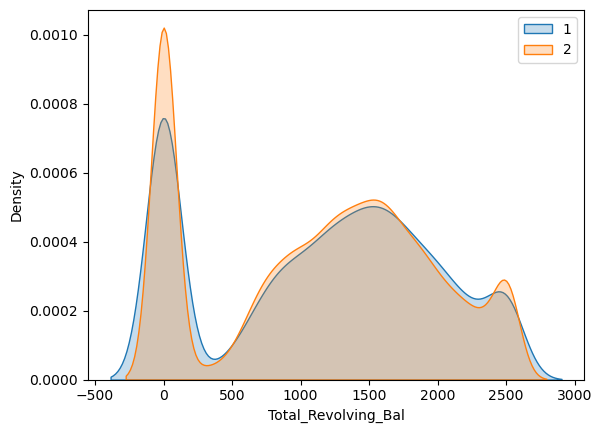

No Drift Detected: Avg_Open_To_Buy


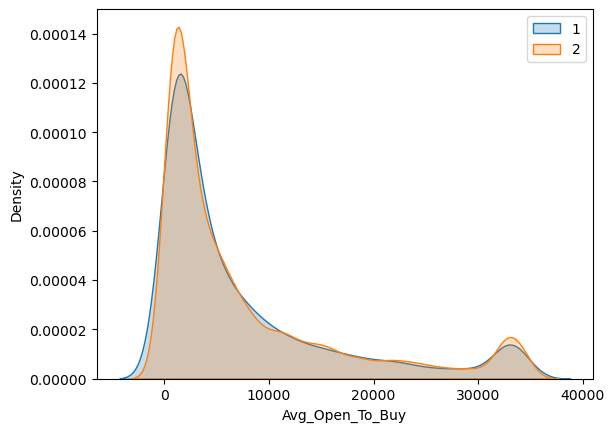

No Drift Detected: Total_Amt_Chng_Q4_Q1


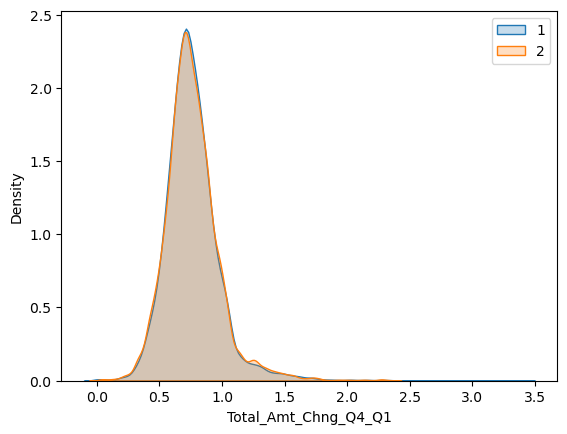

No Drift Detected: Total_Trans_Amt


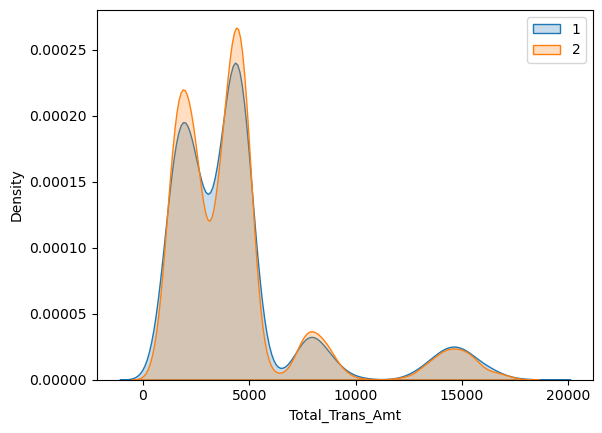

No Drift Detected: Total_Trans_Ct


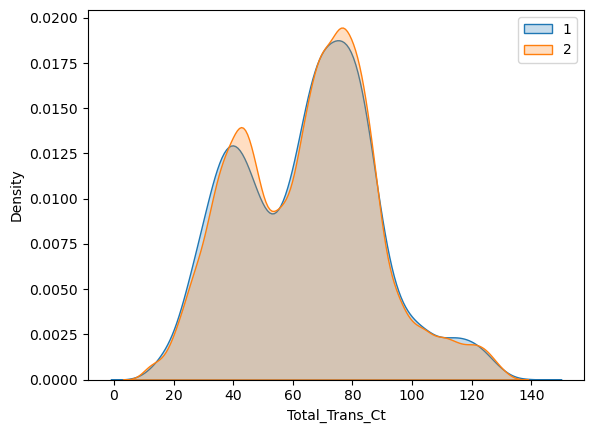

No Drift Detected: Total_Ct_Chng_Q4_Q1


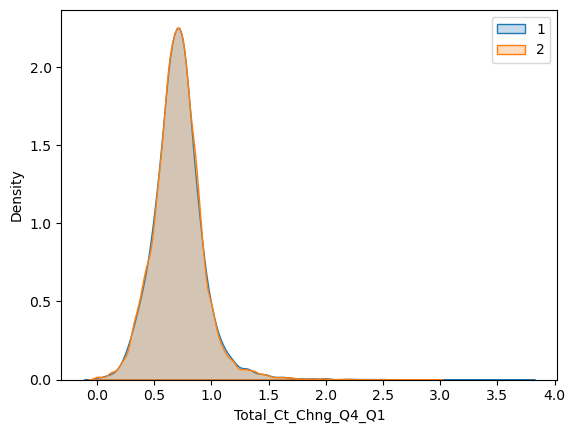

No Drift Detected: Avg_Utilization_Ratio


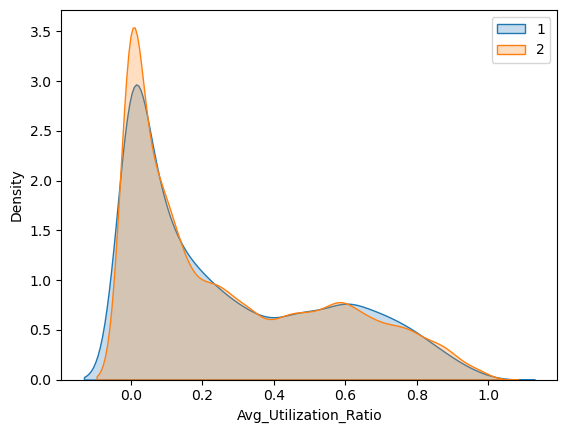

In [314]:
# test drift for original data and second batch of synthetic data
for col in num_col:
    distribution_1 = raw_modeling_df[col]
    distribution_2 = synthetic_modeling_df2[col]
    
    has_drift = calculate_ks(distribution_1, distribution_2, corrected_alpha)
    print(f'Drift Detected: {col}') if has_drift else print(f'No Drift Detected: {col}')
    
    get_kde_plot(distribution_1, distribution_2)